In [2]:
# Importing libraries
from importlib import reload
import time
import json

from kcenters import KCenters
from utils import distance, balance_calculation, plot_analysis, ourFairness
from experiments import run_experiments
from data_loader import DataLoader
from fairlet_decomposition import VanillaFairletDecomposition, MCFFairletDecomposition

import matplotlib.pyplot as plt
%matplotlib inline

## Data Load

In [3]:
source = "census"
normalize = False
degrees = 3

with open('config.json') as json_file:
    config = json.load(json_file)
    
dl = DataLoader(source=source, fair_column=config[source]['fair_column'],
               fair_values=config[source]['fair_values'], distance_columns=config[source]['distance_columns'])
dl.load(normalize)
blues, reds = dl.split(split_size=tuple(config[source]['split_size']), random_state=config[source]['random_state'])


Distribution of 'gender' column -  [('Male', 32650), ('Female', 16192)]

Using these features in addition to gender for clustering -  ['age', 'fnlwgt', 'education_num', 'capital_gain', 'hours_per_week']

Encoding Male as 1, and Female as 0.


## k-Centers

#### k-Centers Warmup

[4.123105625617661, 2.23606797749979, 2.23606797749979]


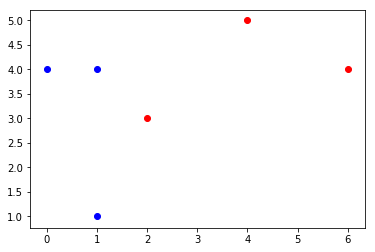

In [18]:
p = [[2, 3], [4, 5], [1,1], [0, 4], [6, 4], [1, 4]]
kcenters = KCenters(k=3)
kcenters.fit(p)

for idx, i in enumerate(p):
    colour = 'blue'
    if idx in kcenters.centers:
        colour = 'red'
    plt.scatter(i[0], i[1], color=colour)
print(kcenters.costs)
plt.show()

#### Unfair k-Centers on the dataset

Time taken for Degree 3 - 0.092 seconds.
Time taken for Degree 4 - 0.107 seconds.
Time taken for Degree 5 - 0.157 seconds.
Time taken for Degree 6 - 0.200 seconds.
Time taken for Degree 7 - 0.271 seconds.
Time taken for Degree 8 - 0.393 seconds.
Time taken for Degree 9 - 0.415 seconds.
Time taken for Degree 10 - 0.543 seconds.
Time taken for Degree 11 - 0.616 seconds.
Time taken for Degree 12 - 0.720 seconds.
Time taken for Degree 13 - 0.806 seconds.
Time taken for Degree 14 - 0.899 seconds.
Time taken for Degree 15 - 1.064 seconds.
Time taken for Degree 16 - 1.228 seconds.
Time taken for Degree 17 - 1.350 seconds.
Time taken for Degree 18 - 1.426 seconds.
Time taken for Degree 19 - 1.663 seconds.
Time taken for Degree 20 - 1.809 seconds.


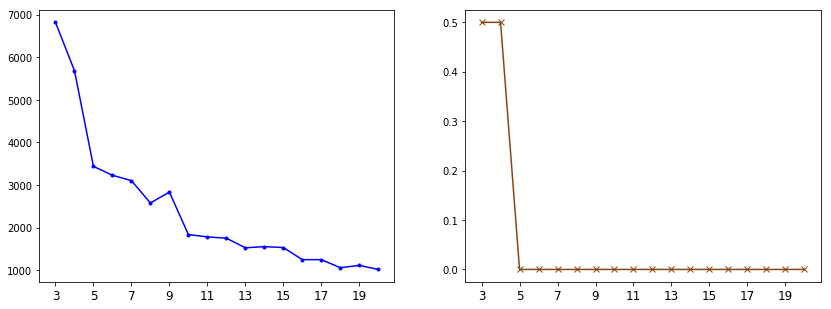

In [7]:
unfair_degrees = []
unfair_costs = []
unfair_balances = []

for degree in range(3, degrees+1, 1):
    start_time = time.time()
    kcenters = KCenters(k=degree)
    kcenters.fit(dl.data_list)
    mapping = kcenters.assign()
    unfair_degrees.append(degree)
    unfair_costs.append(kcenters.costs[-1])
    unfair_balances.append(balance_calculation(dl.data_list, kcenters.centers, mapping))
    print("Time taken for Degree %d - %.3f seconds."%(degree, time.time() - start_time))

plot_analysis(unfair_degrees, unfair_costs, unfair_balances, step_size=2)

### Vanilla Fairlet Decomposition

350 fairlets have been identified.
Time taken for Degree 3 - 0.078 seconds.
Time taken for Degree 4 - 0.101 seconds.
Time taken for Degree 5 - 0.182 seconds.
Time taken for Degree 6 - 0.185 seconds.
Time taken for Degree 7 - 0.283 seconds.
Time taken for Degree 8 - 0.407 seconds.
Time taken for Degree 9 - 0.354 seconds.
Time taken for Degree 10 - 0.436 seconds.
Time taken for Degree 11 - 0.568 seconds.
Time taken for Degree 12 - 0.563 seconds.
Time taken for Degree 13 - 0.564 seconds.
Time taken for Degree 14 - 0.689 seconds.
Time taken for Degree 15 - 0.719 seconds.
Time taken for Degree 16 - 0.839 seconds.
Time taken for Degree 17 - 0.870 seconds.
Time taken for Degree 18 - 0.942 seconds.
Time taken for Degree 19 - 1.324 seconds.
Time taken for Degree 20 - 1.116 seconds.


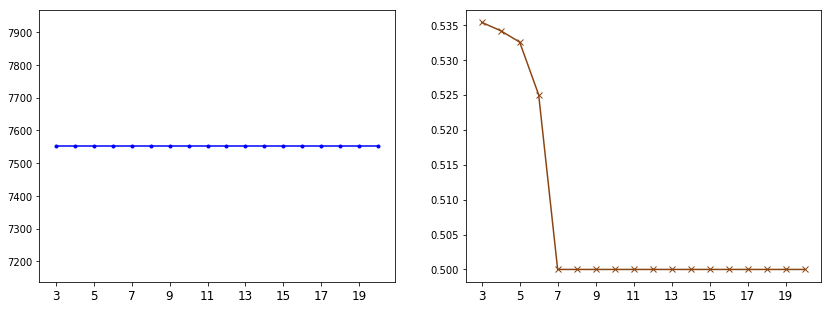

In [28]:
# Instantiating the Vanilla Decomposition per Lemma 3 in NeurIPS 2017 Paper
vfd = VanillaFairletDecomposition(1, 2, blues, reds, dl.data_list)

# Decomposing for fairlets and performing traditional clustering
vanilla_fairlets, vanilla_fairlet_centers, vanilla_fairlet_costs = vfd.decompose()
vanilla_degrees, vanilla_costs, vanilla_balances = run_experiments(degrees, dl.data_list, vanilla_fairlets,
                                                                  vanilla_fairlet_centers)
plot_analysis(vanilla_degrees, vanilla_costs, vanilla_balances, step_size=2)

### MCF Fairlet Decomposition

Graph can't be plotted because the blue nodes exceed 10.
Time taken to compute MCF solution - 63.340 seconds.
182 fairlets have been identified.
Time taken for Degree 1 - 0.016 seconds.
Time taken for Degree 2 - 0.031 seconds.
Time taken for Degree 3 - 0.031 seconds.


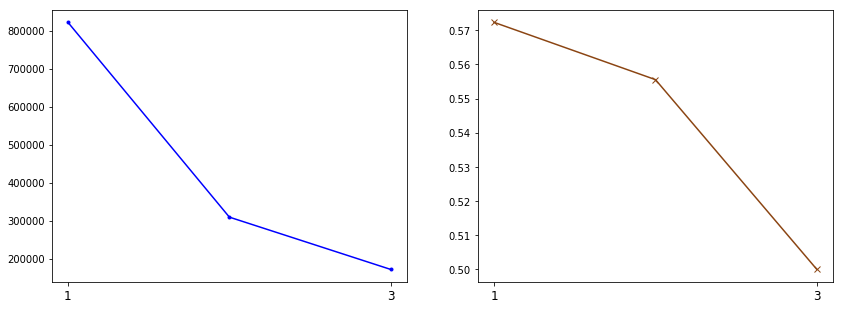

In [4]:
# Instantiating the MCF Decomposition
mcf = MCFFairletDecomposition(blues, reds, 2, config[source]['distance_threshold'], dl.data_list)

# Computing the distance matrix between blue and red nodes
mcf.compute_distances()

# Adding nodes and edges
mcf.build_graph(plot_graph=True)

# Decomposing for fairlets and performing traditional clustering
mcf_fairlets, mcf_fairlet_centers, mcf_fairlet_costs = mcf.decompose()
mcf_degrees, mcf_costs, mcf_balances, final_cluster, final_center = run_experiments(degrees, dl.data_list, mcf_fairlets, mcf_fairlet_centers)
plot_analysis(mcf_degrees, mcf_costs, mcf_balances, step_size=2)

In [5]:
print(mcf_balances)
print(len(mcf_balances))
print(mcf_costs)

[0.5723270440251572, 0.5555555555555556, 0.5]
3
[821540.0007193807, 309047.00219222315, 171403.0019427898]


### Fairness of MCF

In [7]:
reds = 0
for i in dl.data_list:
    if (i[0] == 0):
        reds += 1
        
n = len(dl.data_list)
blues = n - reds

ideal_reds = reds/n
ideal_blues = blues/n

print(reds, blues)
vals = []
for center in final_center:
    
    cluster_reds = 0
    cluster_blues = 0
    cluster_length = 0
    for item in final_cluster:
        if item[1] == center:
            cluster_length += 1
            if (dl.data_list[item[0]]) == 0:
                cluster_reds += 1
    
    cluster_blues = cluster_length - cluster_reds
    cluster_blues /= cluster_length
    cluster_reds /= cluster_length
    vals.append(abs(cluster_blues - ideal_blues) + abs(cluster_reds - ideal_reds))
    
print(max(vals))
    

182 318
0.728


## Final Comparison Plot

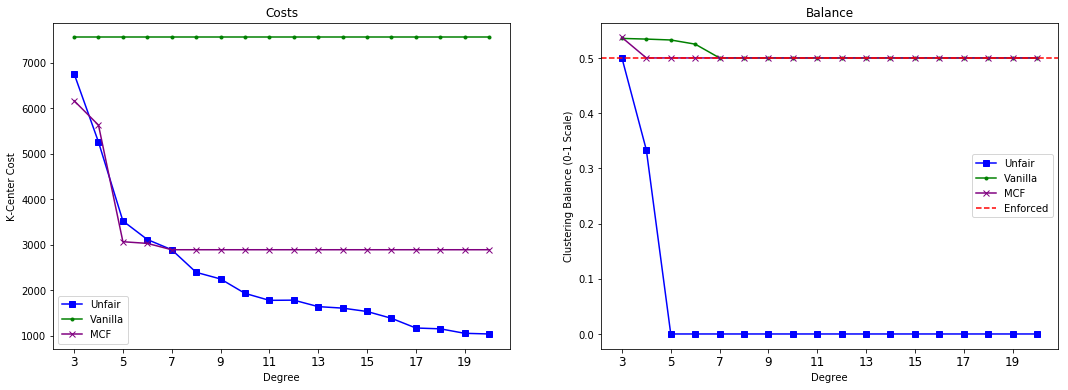

In [30]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
ax[0].plot(unfair_costs, marker='s', color='blue', label="Unfair")
ax[0].plot(vanilla_costs, marker='.', color='green', label="Vanilla")
ax[0].plot(mcf_costs, marker='x', color='purple', label="MCF")
ax[0].set_xticks(list(range(0, len(unfair_degrees), 2))) 
ax[0].set_xticklabels(list(range(min(unfair_degrees), max(unfair_degrees)+1, 2)), fontsize=12)
ax[0].set_title("Costs")
ax[0].set_xlabel("Degree")
ax[0].set_ylabel("K-Center Cost")
ax[0].legend()
ax[1].plot(unfair_balances, marker='s', color='blue', label="Unfair")
ax[1].plot(vanilla_balances, marker='.', color='green', label="Vanilla")
ax[1].plot(mcf_balances, marker='x', color='purple', label="MCF")
ax[1].axhline(0.5, color='red', linestyle='--', label="Enforced")
ax[1].set_xticks(list(range(0, len(unfair_degrees), 2))) 
ax[1].set_xticklabels(list(range(min(unfair_degrees), max(unfair_degrees)+1, 2)), fontsize=12)
ax[1].set_title("Balance")
ax[1].set_xlabel("Degree")
ax[1].set_ylabel("Clustering Balance (0-1 Scale)")
ax[1].legend()
plt.show()